# Statistical Comparison: SGD vs GD

This notebook compares the performance of **Stochastic Gradient Descent (SGD)** and **Gradient Descent (GD)** on a neural network regression task.


In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import time
from scipy import stats

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

print(f"PyTorch version: {torch.__version__}")
print(f"MPS available: {torch.backends.mps.is_available()}")

PyTorch version: 2.9.0
MPS available: True


## Create Challenge Dataset
DO NOT CHANGE THE CODE THAT CREATES THE DATA SET

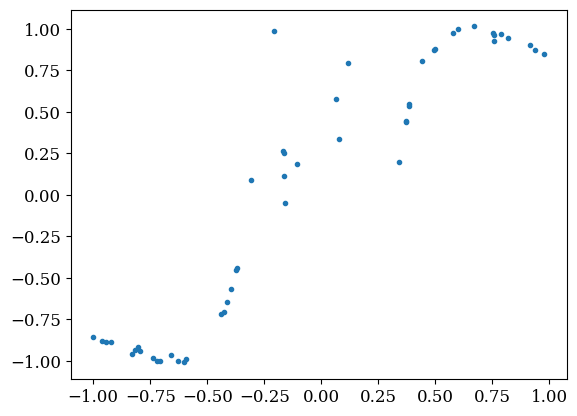

In [17]:
# Define weird function
def weird_fun(x):
    return np.sin(1 / x)


# Reset random seed
np.random.seed(1)

# Set data parameters
N = 50  # Number of observations
s = 0.02  # Noise standard deviation
N_test = 1000  # Number of test observations

# Create training set
x_train = np.sort(np.random.rand(N) * 2 - 1)
y_train = weird_fun(x_train) + s * np.random.randn(N)

# Create test set
x_test = np.sort(np.random.rand(N_test) * 2 - 1)
y_test = weird_fun(x_test) + s * np.random.randn(N_test)

# Plot training data
plt.plot(x_train, y_train, ".")

## Define hyperparameters

In [ ]:
# Here we set the hyperparameters, that both models will use
H = 64  # Hidden units
learning_rate = 0.001
activation = "Tanh" # We choose to use TanH as it will give a smoother curvex
max_epochs = 10_000
num_layers = 3
batch_size = 1

# Device to use for computations
device = torch.device("cpu") # As i am on macbook i will just use cpu

## Create models

In [19]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


# Here i choose to create the model as a function so i easily can create two models
def create_model(H, num_layers, activation):
    activation_fn = getattr(torch.nn, activation)()

    layers = []
    layers.append(torch.nn.Linear(1, H))
    layers.append(activation_fn)

    for _ in range(num_layers - 1):
        layers.append(torch.nn.Linear(H, H))
        layers.append(activation_fn)

    layers.append(torch.nn.Linear(H, 1))

    model = torch.nn.Sequential(*layers)
    return model

## Train models

In [20]:
def train(
    x_train,
    y_train,
    x_test,
    y_test,
    H,
    learning_rate,
    num_layers,
    activation,
    max_epochs,
    device,
    batch_size=None,   
):
    import time
    import torch

    # create tensors
    x = torch.tensor(np.expand_dims(x_train, 1), dtype=torch.float32, device=device)
    y = torch.tensor(np.expand_dims(y_train, 1), dtype=torch.float32, device=device)
    x_test_t = torch.tensor(np.expand_dims(x_test, 1), dtype=torch.float32, device=device)
    y_test_t = torch.tensor(np.expand_dims(y_test, 1), dtype=torch.float32, device=device)

    n_samples = len(x)

    # default batch size (full GD)
    if batch_size is None:
        batch_size = n_samples

    # create model
    model = create_model(H, num_layers, activation).to(device)
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # create dataloader
    dataset = torch.utils.data.TensorDataset(x, y)
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=(batch_size < n_samples), # Only shuffle if we are using batch size smaller then dataset
        drop_last=False,
    )

    Loss_train = []
    Loss_test = []
    start_time = time.time()

    for epoch in range(max_epochs):

        # training
        epoch_loss = 0.0
        for xb, yb in loader:
            y_pred = model(xb)
            loss = loss_fn(y_pred, yb)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(loader)
        Loss_train.append(avg_loss)

        # test
        with torch.no_grad():
            test_pred = model(x_test_t)
            test_loss = loss_fn(test_pred, y_test_t).item()
        Loss_test.append(test_loss)

      

    computation_time = time.time() - start_time

    return {
        "model": model,
        "train_loss": Loss_train,
        "test_loss": Loss_test,
        "final_train_loss": Loss_train[-1],
        "final_test_loss": Loss_test[-1],
        "computation_time": computation_time,
    }


## Run training

In [21]:
# Number of runs
n_trials = 10

gd_results = []
sgd_results = []

for trial in range(n_trials):
    print(f"\nTrial {trial + 1}/{n_trials}")

    torch.manual_seed(42 + trial)
    np.random.seed(42 + trial)

    # Train with GD
    print("  Training with GD...")
    gd_result = train(
        x_train,
        y_train,
        x_test,
        y_test,
        H,
        learning_rate,
        num_layers,
        activation,
        max_epochs,
        device,
        batch_size=None,
    )
    gd_results.append(gd_result)

    # Reset random seed again for fair comparison
    torch.manual_seed(42 + trial)
    np.random.seed(42 + trial)

    # Train with SGD
    print("  Training with SGD...")
    sgd_result = train(
        x_train,
        y_train,
        x_test,
        y_test,
        H,
        learning_rate,
        num_layers,
        activation,
        max_epochs,
        device,
        batch_size=batch_size,
    )
    sgd_results.append(sgd_result)

    print(f"  GD  - Final Test Loss: {gd_result['final_test_loss']:.6f}")
    print(f"  SGD - Final Test Loss: {sgd_result['final_test_loss']:.6f}")


Trial 1/10
  Training with GD...
  Training with SGD...
  GD  - Final Test Loss: 0.272030
  SGD - Final Test Loss: 0.300189

Trial 2/10
  Training with GD...
  Training with SGD...
  GD  - Final Test Loss: 0.271578
  SGD - Final Test Loss: 0.304318

Trial 3/10
  Training with GD...
  Training with SGD...
  GD  - Final Test Loss: 0.270488
  SGD - Final Test Loss: 0.298716

Trial 4/10
  Training with GD...
  Training with SGD...
  GD  - Final Test Loss: 0.270179
  SGD - Final Test Loss: 0.296220

Trial 5/10
  Training with GD...
  Training with SGD...
  GD  - Final Test Loss: 0.270779
  SGD - Final Test Loss: 0.293900

Trial 6/10
  Training with GD...
  Training with SGD...
  GD  - Final Test Loss: 0.271355
  SGD - Final Test Loss: 0.298790

Trial 7/10
  Training with GD...
  Training with SGD...
  GD  - Final Test Loss: 0.269124
  SGD - Final Test Loss: 0.295198

Trial 8/10
  Training with GD...
  Training with SGD...
  GD  - Final Test Loss: 0.272783
  SGD - Final Test Loss: 0.303787


## Statistical Analysis

In [22]:
gd_final_test = [r["final_test_loss"] for r in gd_results]
sgd_final_test = [r["final_test_loss"] for r in sgd_results]

gd_times = [r["computation_time"] for r in gd_results]
sgd_times = [r["computation_time"] for r in sgd_results]

# Mean test loss
gd_mean_loss = np.mean(gd_final_test)
sgd_mean_loss = np.mean(sgd_final_test)

print("Mean Test Loss:")
print(f"  GD:  {gd_mean_loss:.6f}")
print(f"  SGD: {sgd_mean_loss:.6f}")


def ci_95(data):
    mean = np.mean(data)
    sem = stats.sem(data)
    return stats.t.interval(0.95, df=len(data) - 1, loc=mean, scale=sem)

# 95% confidence intervals for test loss
gd_ci_low, gd_ci_high = ci_95(gd_final_test)
sgd_ci_low, sgd_ci_high = ci_95(sgd_final_test)

print("\n95% Confidence Interval (Test Loss):")
print(f"  GD:  [{gd_ci_low:.6f}, {gd_ci_high:.6f}]")
print(f"  SGD: [{sgd_ci_low:.6f}, {sgd_ci_high:.6f}]")


# Mean computation time
gd_mean_time = np.mean(gd_times)
sgd_mean_time = np.mean(sgd_times)

print("\nMean Computation Time:")
print(f"  GD:  {gd_mean_time:.3f} seconds")
print(f"  SGD: {sgd_mean_time:.3f} seconds")

Mean Test Loss:
  GD:  0.271277
  SGD: 0.298734

95% Confidence Interval (Test Loss):
  GD:  [0.270276, 0.272277]
  SGD: [0.295465, 0.302004]

Mean Computation Time:
  GD:  6.418 seconds
  SGD: 10.547 seconds


## Visualize results

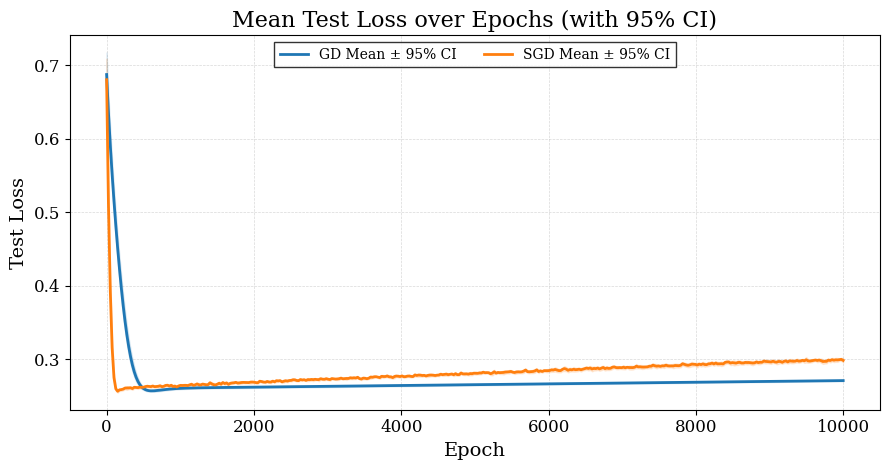

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Extract test losses across trials
gd = np.array([r["test_loss"] for r in gd_results])
sgd = np.array([r["test_loss"] for r in sgd_results])
epochs = np.arange(gd.shape[1])


def mean_ci(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0, ddof=1)
    se = std / np.sqrt(data.shape[0])
    ci95 = 1.96 * se
    return mean, ci95


gd_mean, gd_ci = mean_ci(gd)
sgd_mean, sgd_ci = mean_ci(sgd)


# Downsample for plotting (keeps clarity)
idx = np.linspace(0, len(epochs) - 1, 400).astype(int)

# PGFPlots colors
COLOR_GD = "#1f77b4"
COLOR_SGD = "#ff7f0e"

plt.rcParams.update(
    {
        "font.family": "serif",
        "mathtext.fontset": "cm",
        "axes.edgecolor": "black",
        "axes.linewidth": 0.8,
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "grid.color": "gray",
        "grid.linewidth": 0.5,
        "grid.alpha": 0.3,
        "legend.frameon": True,
        "legend.edgecolor": "black",
        "legend.fancybox": False,
    }
)

fig, ax = plt.subplots(figsize=(9, 4.8))

# Shaded CI regions
ax.fill_between(
    epochs[idx],
    gd_mean[idx] - gd_ci[idx],
    gd_mean[idx] + gd_ci[idx],
    color=COLOR_GD,
    alpha=0.15,
)
ax.fill_between(
    epochs[idx],
    sgd_mean[idx] - sgd_ci[idx],
    sgd_mean[idx] + sgd_ci[idx],
    color=COLOR_SGD,
    alpha=0.15,
)

# Mean curves
ax.plot(
    epochs[idx], gd_mean[idx], color=COLOR_GD, linewidth=2, label="GD Mean ± 95% CI"
)
ax.plot(
    epochs[idx],
    sgd_mean[idx],
    color=COLOR_SGD,
    linewidth=2,
    label="SGD Mean ± 95% CI",
)

# Labels and title
ax.set_xlabel("Epoch")
ax.set_ylabel("Test Loss")
ax.set_title("Mean Test Loss over Epochs (with 95% CI)", fontsize=16)

# Move legend below title
ax.legend(loc="upper center", ncol=2, frameon=True)

ax.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()